# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-02-14 05:14:18.577099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 05:14:18.587214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 05:14:18.587965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Import Data

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# cahe_dir will cache the datset into current directory
# while cache_subdir will tell it if it needs a folder 
# for keeping the dataset inside the cache_dir
dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

# Sampling the dataset

In [4]:
os.listdir(dataset_dir)

['README', 'test', 'imdb.vocab', 'train', 'imdbEr.txt']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsupBow.feat',
 'labeledBow.feat',
 'urls_pos.txt',
 'unsup',
 'pos',
 'urls_neg.txt',
 'urls_unsup.txt',
 'neg']

In [6]:
os.listdir(os.path.join(dataset_dir, 'test'))

['labeledBow.feat', 'urls_pos.txt', 'pos', 'urls_neg.txt', 'neg']

In [7]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [8]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

# Train, valid, test dataset + Batch

In [9]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2023-02-14 05:14:45.316007: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 05:14:45.316430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 05:14:45.317348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 05:14:45.318014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


# Text Vectorization Layer Definition + Vocab

Note we are vectorizing the text, not creating embeddings diretly here

In [13]:
# jus look past this for now; just a custom standardization for the TextVectorization layer.

# works on each example of the batch for every batch.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [14]:
max_features = 10000
sequence_length = 250

# max_tokens = capping the max size of vocabulary
# standardize using a custom function--> passes single example as input to the function and
# standarizes and returns
# output_mode; int --> one integer index per split string token
# multi-hot --> single output int array per batch

# output_sequence_length (only for int mode)--> each example has same sequence or
# length of timestamp of vector

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

next(iter(raw_train_ds))[0][0]

## would work better if we reduce each word/ token to its base form?

## Train text here; just for making vocab

In [15]:
# Make a text-only dataset (without labels), then call adapt
# x, y are variables assigned to each batch; only x is returned

train_text = raw_train_ds.map(lambda x, y: x)

# calling adapt will result in construction of vocabulary for the layer
# when vocab is capped, its prioritized based on the words with higher frequency
vectorize_layer.adapt(train_text)

2023-02-14 05:14:48.440179: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


next(iter(train_text))[0]

# Function for using Vectorization

In [16]:
def vectorize_text(text, label):
    # expand_dims will just increase the dimension at -1 axis (Last axis)
    # expand_dims will change the shape of example from (None,) to (None, 1)
    
    # this is done as textvectorization layer will take input of an array
    
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

### Sample vectorization

In [17]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review: ", first_review)
print("Label: ", raw_train_ds.class_names[first_label])
print("Vectorized review: ", vectorize_text(first_review, first_label))

Review:  tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br /

In [18]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [19]:
 for i in vectorize_layer('Hello, how are you doing this morning? Are you still working on those file I sent you. Zub'):
        if i != 0:
            print(vectorize_layer.get_vocabulary()[i],f'--> {i}')

hello --> 5128
how --> 87
are --> 23
you --> 22
doing --> 384
this --> 11
morning --> 1947
are --> 23
you --> 22
still --> 125
working --> 773
on --> 20
those --> 143
file --> 8101
i --> 10
sent --> 1337
you --> 22
[UNK] --> 1


In [20]:
vectorize_layer.get_vocabulary()[0]

''

# Vectorizing each text inputs

In [21]:
# vetorization will happen to each examples inside the batch

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### just checking what does expand_dims do?

Note that in above function; expand_dims is used for single example using map method

In [22]:
temp_x, temp_y = next(iter(train_ds))

In [23]:
print(temp_x.shape)
temp_x[0]

(32, 250)


<tf.Tensor: shape=(250,), dtype=int64, numpy=
array([  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
          1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

In [24]:
print(tf.expand_dims(temp_x,-1).shape)
tf.expand_dims(temp_x,-1)[1].shape

(32, 250, 1)


TensorShape([250, 1])

# Pre-fetching: for efficient model

In [25]:
# AUTOTUNE will deligate the input of buffer size to tf.data
# which will tune the value dynamically in the run-time.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modeling the embedding layer and dense layer

with regularization for overfitting

In [26]:
embedding_dim = 64

Embedding Layer:

input layers are preprocessed and TextVectorization can help with that
<br>input-dim --> Size of vocabulary ( index + 1 )
<br>output-dim --> Square matrix shape (Embedding matrix)
<br>

In [49]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim, input_length = 250),
#     layers.GlobalAveragePooling1D(),
    layers.Bidirectional(layers.LSTM(2)),
#     layers.Dropout(0.5),
    layers.Dense(100),
#     layers.Dropout(0.5),
    layers.Dense(1)])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 64)           640064    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 4)                 1072      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               500       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 641,737
Trainable params: 641,737
Non-trainable params: 0
_________________________________________________________________


In [28]:
input_shape = (2, 3, 4)
x = tf.random.normal(input_shape)
y = tf.keras.layers.GlobalAveragePooling1D()(x)
print(y.shape)
print(x)
print(y)

(2, 4)
tf.Tensor(
[[[ 0.49907866 -0.8883284  -0.96376073  0.5035114 ]
  [ 0.26955134  0.4852963  -2.323299    1.674998  ]
  [-0.16353881  0.26483664 -1.4359219  -1.2665247 ]]

 [[-1.0373251  -1.7970939  -0.33213112 -1.5372416 ]
  [ 0.8614056  -0.559979    0.7760651  -0.4909836 ]
  [ 0.30302316  1.0343845  -0.6955812  -0.45805013]]], shape=(2, 3, 4), dtype=float32)
tf.Tensor(
[[ 0.20169707 -0.04606514 -1.5743271   0.30399492]
 [ 0.04236788 -0.44089612 -0.0838824  -0.8287584 ]], shape=(2, 4), dtype=float32)


In [50]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

In [51]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 15s 20ms/step - loss: 0.5166 - binary_accuracy: 0.7324 - val_loss: 0.4358 - val_binary_accuracy: 0.8124
Epoch 2/10
625/625 [==============================] - 12s 19ms/step - loss: 0.3289 - binary_accuracy: 0.8695 - val_loss: 0.4031 - val_binary_accuracy: 0.8266
Epoch 3/10
625/625 [==============================] - 12s 19ms/step - loss: 0.2396 - binary_accuracy: 0.9108 - val_loss: 0.4199 - val_binary_accuracy: 0.8436
Epoch 4/10
625/625 [==============================] - 12s 19ms/step - loss: 0.1818 - binary_accuracy: 0.9348 - val_loss: 0.4604 - val_binary_accuracy: 0.8348
Epoch 5/10
625/625 [==============================] - 12s 19ms/step - loss: 0.1361 - binary_accuracy: 0.9547 - val_loss: 0.5350 - val_binary_accuracy: 0.8248
Epoch 6/10
625/625 [==============================] - 12s 19ms/step - loss: 0.1062 - binary_accuracy: 0.9661 - val_loss: 0.5720 - val_binary_accuracy: 0.8314
Epoch 7/10
625/625 [==============================] 

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fa2708bca70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


625/625 [==============================] - 12s 19ms/step - loss: 0.0673 - binary_accuracy: 0.9791 - val_loss: 0.7843 - val_binary_accuracy: 0.8300
Epoch 10/10
625/625 [==============================] - 12s 19ms/step - loss: 0.0527 - binary_accuracy: 0.9851 - val_loss: 0.7649 - val_binary_accuracy: 0.8106


In [31]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.4633 - binary_accuracy: 0.8194
Loss:  0.4633050858974457
Accuracy:  0.8194000124931335


In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

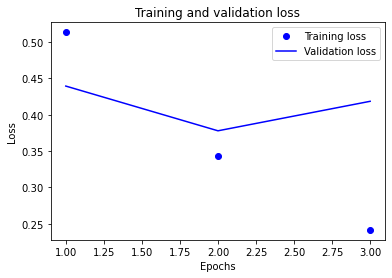

In [33]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

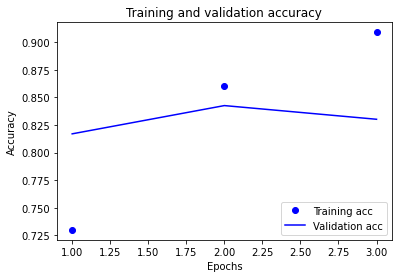

In [34]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Single whole model (export_model)

In [35]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 10s 12ms/step - loss: 0.4633 - accuracy: 0.8272
0.827239990234375


# Real world test sample

In [36]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.62343425],
       [0.3914408 ],
       [0.13069001]], dtype=float32)

___

In [37]:
export_model.predict(["I like the movie"])

array([[0.46988964]], dtype=float32)

### Both above and below has almost same semantics but shows completely diff prediction; must be due to vocab; using root word would improve the model by a lot

In [38]:
export_model.predict(["I liked the movie"])

array([[0.7299369]], dtype=float32)

___

In [39]:
export_model.predict(["I did not like the movie"])

array([[0.32731852]], dtype=float32)

In [40]:
export_model.predict(["I do not like the movie"])

array([[0.3280654]], dtype=float32)

___

In [41]:
export_model.predict(["The series was too bad"])

array([[0.15410994]], dtype=float32)

## We can see the other problem of this model; the input text should be long in order to be correctly predicting; as long text has lot of semantics to get prediction from --> again the problem is rooted in root words and lack of root vocab

In [42]:
export_model.predict(["It's incredible how clear images Cameron managed to create with this 3d. Although Avatar was more colorful and creative, the sequel has it's strength in the high-frame 3d scenes, with a quality I've never seen before! But the movie and storytelling itself is a big disappointment... The same speech of family staying together, with their kids doing stupid decisions during the ENTIRE movie, fighting against the bad guys (with no cohesive intentions), bla bla bla bla.... The movie feels like a preparation for next movie (which could be done with a cartoon series).The formula is the same, characters are almost the same, less creative than the first one, all the Hollywood clichés... I can't say this is a good movie, unfortunately, and I'll probably never watch it again!"])

array([[0.30945408]], dtype=float32)

## No RNN used here, so model seems to only search for certain individual words for predicting Sentiment

## Bi-directional LSTM used to check the model accuracy